## Pregunta  4: Aplicación de una red neuronal en Localización

Desde la edad antigua, múltiples formas de localización han sido desarrolladas. Dentro de los avances más importantes en este ámbito, es el desarrollo de la teorı́a cientı́fica y técnica denominada georreferenciación. Gracias a GPS, el crecimiento y acceso de la georreferenciación y navegación está en progresivo aumento, el problema surge cuando se intentan estimar en recintos interiores (como edificios o bajo tierra) donde el GPS no funciona de la manera como uno esperaría, debido a que existen muchos obstáculos e interferencia que imposibilitan su uso.
Dentro de interiores se cuenta con señales RSSI (fingerprint) que pueden atacar este problema, sin embargo los métodos actuales no son robustos a ruido, por lo que su tarea será la de abordar este problema para mejorar exactitud de sistemas de posicionamiento en interiores mediante redes neuronales.

La metodología con la que se trabajará será que, para dentro de interiores, dispositivos Bluetooth emiten señales RSSI las cuales son captadas por el dispositivo "objetivo" al cual se le desea determinar su localización, recibiendo distintas intensidades de señal de cada dispositivo emisor debido a su posición en el interior. Los datos con los que se va a trabajar (IndoorFingerprint.csv) fueron provistos por el nuevo Ing. Civil Informático Felipe Berrios, éstos constan de 8 características (C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI) correspondientes a las mediciones hechas/recibidas por el dispositivo "objetivo" de las distintas señales RSSI emitidas por los dispositivos Bluetooth en los bordes del interior, además de tener la posición del dispositivo "objetivo" en un plano XY (valor a estimar).

Una consideración importante es el cómo tratar la ausencia de la señal proveniente de un dispositivo Bluetooth, para estos datos se utiliza un valor de +100, ya que es imposible obtener este valor debido a las características de la escala RSSI (siempre negativa o igual a cero), pero puede ser sustituido por otro.
Para hacer el trabajo mas simple se discretizará la posición en el plano definiendo zonas en dónde está el objeto a localizar. Las zonas deben ser las que indica la malla a continuación:

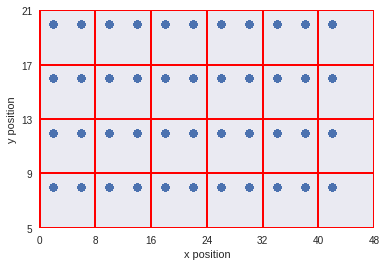

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("./IndoorFingerprint.csv")
 
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

Donde los puntos azules son los distintos datos superpuestos de las posiciones del objeto a localizar. Por ejemplo el punto (2,8) está en la primera zona (o en la primera zona del eje x y del eje y), el punto (2,20) está en la zona 19 (o en la primera zona del eje x y la cuarta zona del eje y). Esta discretización transforma el problema que en un principio podría ser de regresión para determinar la posición exacta, en un problema de clasificación dividiendo (dentro de los posibles valores) 6 zonas para el eje "x" y 4 zonas para el eje "y", contando con un total de 24 clases (24 zonas en la malla).



Se entrenará una red feed forward para la clasificación de las 24 posibles clases, donde tal red debe obtener un desempeño (accuracy) mayor al 75%.


A continuación se visualiza un resumen de los datos que se tienen como input, mediante la función *describe*.


In [3]:
print(df.shape)
df.describe()

(6600, 10)


,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
count,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000
mean,22.000000,14.000000,-71.152121,-85.025909,-89.734545,-77.810758,-90.219091,-80.133030,-89.091515,-89.195455
std,12.650069,4.472475,61.117550,38.743163,7.763426,43.540421,9.230207,7.715085,7.296616,9.508659
min,2.000000,8.000000,-105.000000,-104.000000,-107.000000,-103.000000,-105.000000,-102.000000,-102.000000,-105.000000
25%,10.000000,11.000000,-98.000000,-97.000000,-96.000000,-96.000000,-96.000000,-86.000000,-95.000000,-96.000000
50%,22.000000,14.000000,-93.000000,-94.000000,-92.000000,-87.000000,-91.000000,-80.000000,-90.000000,-90.500000
75%,34.000000,17.000000,-86.000000,-90.000000,-84.000000,-80.000000,-86.000000,-75.000000,-85.000000,-84.000000
max,42.000000,20.000000,100.000000,100.000000,-65.000000,100.000000,100.000000,-57.000000,-60.000000,100.000000


In [4]:
df.head()

,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
0,2.0,8.0,-66,-92,-84,-84,-92,-93,-98,-96
1,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-96
2,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-100
3,2.0,8.0,-66,-94,-84,-84,-94,-80,-98,-100
4,2.0,8.0,-66,-94,-84,-84,-94,-74,-98,-100



Importante
El conjunto de pruebas está fijado a través de los indices de posiciones del dataset, por lo que deberá leer estos indices y crear el conjunto de pruebas a partir de éstos.

Es una buena práctica el normalizar los datos antes de trabajar con los modelos

A continuación se genera el conjunto de entrenamiento y de pruebas. Primero se lee el archivo 'mask_test.csv', el cual indica los indices de las posiciones en el dataset que conforman el conjunto de pruebas.

In [0]:
mask_test = np.loadtxt('mask_test.csv',dtype="i")
X = df.as_matrix()
#X_test = X[mask_test]
#X_train = np.delete(X,mask_test,axis=0)

In [10]:
df.shape

(6600, 10)

In [11]:
print(len(X))

6600


Luego, se identifica en que posición de la grilla se encuentra cada punto, según la variable *X* e *Y* del dataset original, las cuales se comparan con *x_ticks* e *y_ticks* respectivamente para efectivamente saber la grilla en que se encuentre.

In [46]:
np.where(y_ticks>20)[0][0]

(array([4]),)

In [0]:
n = 24
posiciones_grilla = []
for i in X:
    #print(i[0], i[1])
    x = np.where(x_ticks>i[0])[0][0]
    y = np.where(y_ticks>i[1])[0][0]
    posiciones_grilla.append((x,y))

In [13]:
print(posiciones_grilla)

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1),

In [0]:
y_labels = pd.get_dummies(posiciones_grilla)

In [15]:
print(y_labels.head)
y_labels.tail

<bound method DataFrame.head of       (1, 1)  (1, 2)  (1, 3)  (1, 4)  (2, 1)  (2, 2)  (2, 3)  (2, 4)  (3, 1)  \
0          1       0       0       0       0       0       0       0       0   
1          1       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          1       0       0       0       0       0       0       0       0   
4          1       0       0       0       0       0       0       0       0   
5          1       0       0       0       0       0       0       0       0   
6          1       0       0       0       0       0       0       0       0   
7          1       0       0       0       0       0       0       0       0   
8          1       0       0       0       0       0       0       0       0   
9          1       0       0       0       0       0       0       0       0   
10         1       0       0       0       0       0       0       0       0   
11      

<bound method DataFrame.tail of       (1, 1)  (1, 2)  (1, 3)  (1, 4)  (2, 1)  (2, 2)  (2, 3)  (2, 4)  (3, 1)  \
0          1       0       0       0       0       0       0       0       0   
1          1       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          1       0       0       0       0       0       0       0       0   
4          1       0       0       0       0       0       0       0       0   
5          1       0       0       0       0       0       0       0       0   
6          1       0       0       0       0       0       0       0       0   
7          1       0       0       0       0       0       0       0       0   
8          1       0       0       0       0       0       0       0       0   
9          1       0       0       0       0       0       0       0       0   
10         1       0       0       0       0       0       0       0       0   
11      

In [0]:
df.drop(["X","Y"],axis=1,inplace=True)
X = df.as_matrix()
X_test = X[mask_test]
X_train = np.delete(X,mask_test,axis=0)

Y = y_labels.as_matrix()
Y_test = Y[mask_test]
Y_train = np.delete(Y,mask_test,axis=0)

In [17]:
print(len(X_train)+len(X_test))
print(len(Y_train)+len(Y_test))

6600
6600


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
scaler_test = StandardScaler().fit(X_test)
X_test_scaled = scaler_test.transform(X_test)

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


In [26]:
print(X_train.shape)

(4620, 8)


In [34]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(400, kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(24, activation='softmax'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               1800      
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)               80400     
_________________________________________________________________
activation_5 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               80200     
_________________________________________________________________
activation_6 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                4824      
Total para

In [0]:
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model_fit = model.fit(X_train_scaled, Y_train, epochs=300, verbose=1, validation_data=(X_test_scaled, Y_test), shuffle=True)

Train on 4620 samples, validate on 1980 samples
Epoch 1/300
4620/4620 [==============================] - 1s 154us/step - loss: 3.1766 - acc: 0.0790 - val_loss: 3.1753 - val_acc: 0.0864
Epoch 2/300
4620/4620 [==============================] - 1s 125us/step - loss: 3.1729 - acc: 0.0978 - val_loss: 3.1716 - val_acc: 0.1141
Epoch 3/300
4620/4620 [==============================] - 1s 130us/step - loss: 3.1693 - acc: 0.1390 - val_loss: 3.1680 - val_acc: 0.1641
Epoch 4/300
4620/4620 [==============================] - 1s 141us/step - loss: 3.1657 - acc: 0.1745 - val_loss: 3.1645 - val_acc: 0.1758
Epoch 5/300
4620/4620 [==============================] - 1s 139us/step - loss: 3.1622 - acc: 0.1872 - val_loss: 3.1610 - val_acc: 0.1843
Epoch 6/300
4620/4620 [==============================] - 1s 136us/step - loss: 3.1587 - acc: 0.1965 - val_loss: 3.1576 - val_acc: 0.1980
Epoch 7/300
4620/4620 [==============================] - 1s 137us/step - loss: 3.1552 - acc: 0.2069 - val_loss: 3.1541 - val_acc: 

1696/4620 [==========>...................] - ETA: 0s - loss: 2.6693 - acc: 0.33084620/4620 [==============================] - 1s 144us/step - loss: 2.6583 - acc: 0.3327 - val_loss: 2.6512 - val_acc: 0.3131
Epoch 62/300
4620/4620 [==============================] - 1s 142us/step - loss: 2.6368 - acc: 0.3372 - val_loss: 2.6294 - val_acc: 0.3187
Epoch 63/300
4620/4620 [==============================] - 1s 143us/step - loss: 2.6148 - acc: 0.3416 - val_loss: 2.6070 - val_acc: 0.3237
Epoch 64/300
4620/4620 [==============================] - 1s 145us/step - loss: 2.5923 - acc: 0.3439 - val_loss: 2.5841 - val_acc: 0.3247
Epoch 65/300
4620/4620 [==============================] - 1s 145us/step - loss: 2.5693 - acc: 0.3481 - val_loss: 2.5607 - val_acc: 0.3273
Epoch 66/300
4620/4620 [==============================] - 1s 148us/step - loss: 2.5458 - acc: 0.3489 - val_loss: 2.5368 - val_acc: 0.3308
Epoch 67/300
4620/4620 [==============================] - 1s 144us/step - loss: 2.5219 - acc: 0.3519 - v

3584/4620 [======================>.......] - ETA: 0s - loss: 1.3682 - acc: 0.59324620/4620 [==============================] - 1s 132us/step - loss: 1.3668 - acc: 0.5900 - val_loss: 1.3458 - val_acc: 0.5949
Epoch 122/300
4620/4620 [==============================] - 1s 142us/step - loss: 1.3548 - acc: 0.5924 - val_loss: 1.3342 - val_acc: 0.6005
Epoch 123/300
4620/4620 [==============================] - 1s 138us/step - loss: 1.3431 - acc: 0.6082 - val_loss: 1.3223 - val_acc: 0.6000
Epoch 124/300
4620/4620 [==============================] - 1s 136us/step - loss: 1.3319 - acc: 0.5955 - val_loss: 1.3110 - val_acc: 0.5995
Epoch 125/300
4620/4620 [==============================] - 1s 137us/step - loss: 1.3209 - acc: 0.6028 - val_loss: 1.3005 - val_acc: 0.6091
Epoch 126/300
4620/4620 [==============================] - 1s 135us/step - loss: 1.3102 - acc: 0.6093 - val_loss: 1.2900 - val_acc: 0.6121
Epoch 127/300
4620/4620 [==============================] - 1s 135us/step - loss: 1.2995 - acc: 0.61

3328/4620 [====================>.........] - ETA: 0s - loss: 0.9122 - acc: 0.72754620/4620 [==============================] - 1s 142us/step - loss: 0.9078 - acc: 0.7253 - val_loss: 0.8974 - val_acc: 0.7232
Epoch 182/300
4620/4620 [==============================] - 1s 145us/step - loss: 0.9033 - acc: 0.7260 - val_loss: 0.8930 - val_acc: 0.7283
Epoch 183/300
4620/4620 [==============================] - 1s 137us/step - loss: 0.8984 - acc: 0.7284 - val_loss: 0.8875 - val_acc: 0.7354
Epoch 184/300
4620/4620 [==============================] - 1s 134us/step - loss: 0.8935 - acc: 0.7294 - val_loss: 0.8842 - val_acc: 0.7374
Epoch 185/300
4620/4620 [==============================] - 1s 140us/step - loss: 0.8888 - acc: 0.7348 - val_loss: 0.8789 - val_acc: 0.7374
Epoch 186/300
4620/4620 [==============================] - 1s 138us/step - loss: 0.8843 - acc: 0.7316 - val_loss: 0.8747 - val_acc: 0.7343
Epoch 187/300
4620/4620 [==============================] - 1s 139us/step - loss: 0.8797 - acc: 0.73

3008/4620 [==================>...........] - ETA: 0s - loss: 0.7199 - acc: 0.78364620/4620 [==============================] - 1s 140us/step - loss: 0.7073 - acc: 0.7913 - val_loss: 0.7145 - val_acc: 0.7848
Epoch 242/300
4620/4620 [==============================] - 1s 139us/step - loss: 0.7049 - acc: 0.7881 - val_loss: 0.7109 - val_acc: 0.7859
Epoch 243/300
4620/4620 [==============================] - 1s 142us/step - loss: 0.7027 - acc: 0.7920 - val_loss: 0.7092 - val_acc: 0.7899
Epoch 244/300
4620/4620 [==============================] - 1s 139us/step - loss: 0.7005 - acc: 0.7918 - val_loss: 0.7080 - val_acc: 0.7899
Epoch 245/300
4620/4620 [==============================] - 1s 144us/step - loss: 0.6981 - acc: 0.7929 - val_loss: 0.7067 - val_acc: 0.7894
Epoch 246/300
4620/4620 [==============================] - 1s 144us/step - loss: 0.6961 - acc: 0.7942 - val_loss: 0.7043 - val_acc: 0.7909
Epoch 247/300
4620/4620 [==============================] - 1s 146us/step - loss: 0.6939 - acc: 0.79

In [38]:
score = model.evaluate(X_test_scaled, Y_test)

1980/1980 [==============================] - 0s 36us/step


In [39]:
print("Cross entropy loss:", score[0])
print("Accuracy: ", score[1])

('Cross entropy loss:', 0.6146909827535803)
('Accuracy: ', 0.8106060609673009)


In [0]:
def plot(hist):
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(loss) + 1)
  
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(epochs, loss, 'bo-', label = "Training set")
    ax.plot(epochs, val_loss, 'go-', label = "Test set")
    ax.set_title('Loss de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc="upper right", fancybox= True)

    acc = hist['acc']
    val_acc = hist['val_acc']
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(epochs, np.subtract(1,acc), 'bo-', label = "Training set")
    ax.plot(epochs, np.subtract(1,val_acc), 'go-', label = "Test set")
    ax.set_title('Error de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.legend(loc="upper right", fancybox= True)
    plt.show()

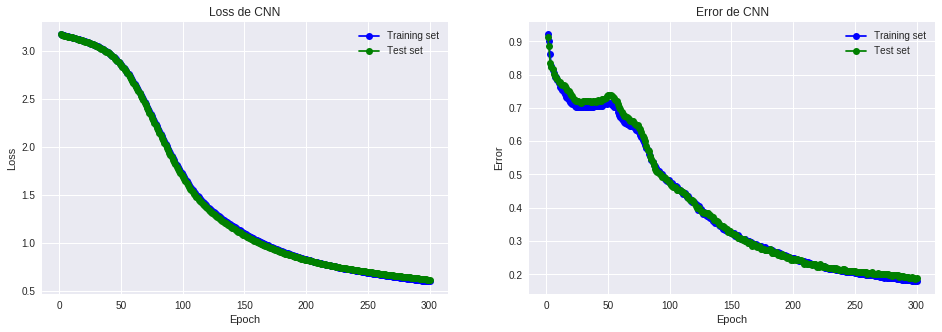

In [44]:
plot(model_fit.history)